# Data Mining Assignment 2
by Fayyaz Minhas

Version: Feb 16, 2024

## Image Data Download

You can do it manually as well from the given URL.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!wget https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/patches_256.zip
#!unzip /content/patches_256.zip -d /content/

## Download and load expression data into a dataframe

This data can be read using this code (not to be changed). Each row in the resulting data frame contains information about a single spot such as its spatial location coordinates (Location_Center_Y, Location_Center_X) and the expression values of 38 different proteins. The names of the proteins are given in the list “proteins_names”.  The code  also creates two additional columns 'specimen_id' and 'image_id' which will be needed for this assignment. df.specimen_id contains the identifier or name of the specimen (A1, B1, C1 or D1) from which the spot originates.  df.image_id contains the file name of the image file corresponding to each spot (without the png extension).

Note there may be some images for which no expression is available. You can drop those images.


In [2]:
import pandas as pd
df = pd.read_csv('https://warwick.ac.uk/fac/sci/dcs/teaching/material/cs909/protein_expression_data.csv')


df['specimen_id']=df.VisSpot.apply(lambda x: x.split('-')[2]) #create specimen id field
df['image_id']=df.VisSpot.apply(lambda x: x.split('-')[2])+'_'+df.id #create image id field
df = df.set_index('image_id').sort_index()
protein_names = ['SMAa', 'CD11b',
       'CD44', 'CD31', 'CDK4', 'YKL40', 'CD11c', 'HIF1a', 'CD24', 'TMEM119',
       'OLIG2', 'GFAP', 'VISTA', 'IBA1', 'CD206', 'PTEN', 'NESTIN', 'TCIRG1',
       'CD74', 'MET', 'P2RY12', 'CD163', 'S100B', 'cMYC', 'pERK', 'EGFR',
       'SOX2', 'HLADR', 'PDGFRa', 'MCT4', 'DNA1', 'DNA3', 'MHCI', 'CD68',
       'CD14', 'KI67', 'CD16', 'SOX10']
print(df)


          Unnamed: 0                VisSpot  Location_Center_Y  \
image_id                                                         
A1_0x40          412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
A1_0x42         7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
A1_0x44         8102  TCACTCAGCGCATTAG-1-A1         832.902467   
A1_0x46         7085  GTGCGCTTACAAATGA-1-A1         858.343544   
A1_0x48         3748  CGAAGACTGCCCGGGA-1-A1         892.179831   
...              ...                    ...                ...   
D1_9x63         3609  CCTCCCGACAATCCCT-1-D1         123.760525   
D1_9x65          172  AACACGACTGTACTGA-1-D1          29.281573   
D1_9x67         2686  CACCGCCGACCAGCGA-1-D1         938.403662   
D1_9x69         2813  CAGAGTGATTTAACGT-1-D1         844.093656   
D1_9x71         6877  GTCAGTTGTGCTCGTT-1-D1         740.107483   

          Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  \
image_id                                                    

# Showing an example image

The code below will load an example image. It also shows how you can get the HED channels.

In [ ]:
image_folder = '/content/drive/MyDrive/data mining lab/assignment 2/patches_256'
filtered_df = df[df['specimen_id'].isin(['A1', 'B1', 'D1'])]

skimage version 0.19.3


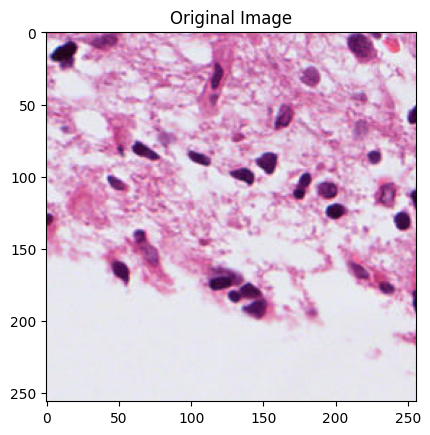

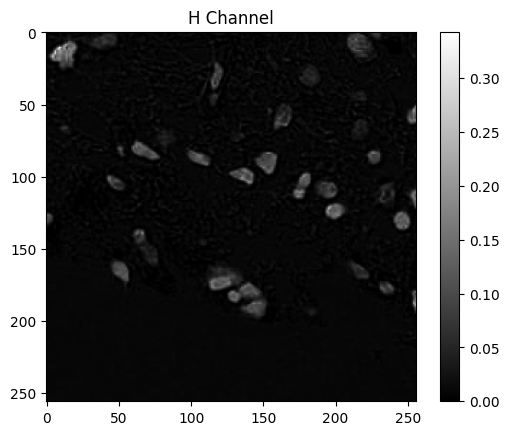

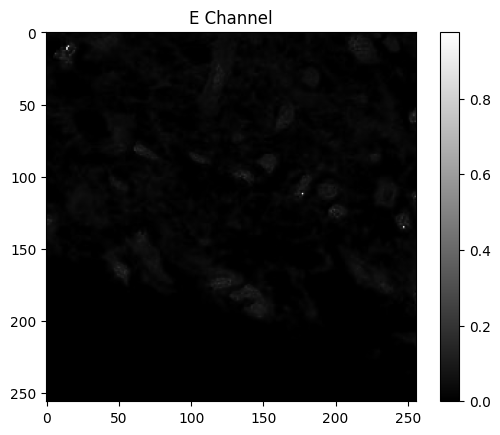

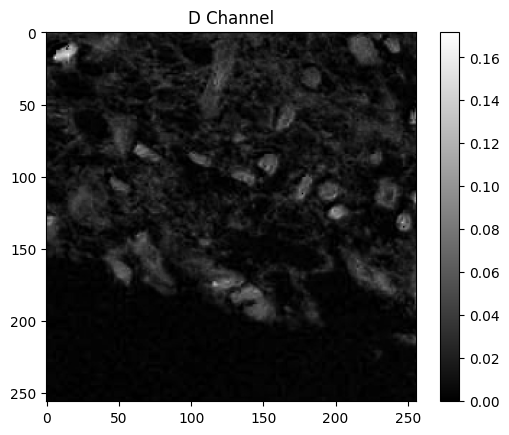

In [ ]:
image_folder = '/content/drive/MyDrive/data mining lab/assignment 2/patches_256'
from skimage.color import rgb2hed
import skimage
from skimage.io import imread
from skimage.color import rgba2rgb
import matplotlib.pyplot as plt
print('skimage version',skimage.__version__)

# Replace 'path_to_image' with the path to the image you want to display
example_image_path = image_folder+'/A1_0x40.png'
I = rgba2rgb(imread(example_image_path)) #read sample RGB image
I_hed =  rgb2hed(I) #convert to HED
plt.imshow(I);plt.title('Original Image');plt.show()
I_h = I_hed[:,:,0]; plt.figure(); plt.imshow(I_h,cmap='gray');plt.colorbar();plt.title('H Channel');plt.show()
I_e = I_hed[:,:,1]; plt.figure();  plt.imshow(I_e,cmap='gray');plt.colorbar();plt.title('E Channel');plt.show()
I_d = I_hed[:,:,2]; plt.figure();  plt.imshow(I_d,cmap='gray');plt.colorbar();plt.title('D Channel');plt.show()


## Useful hints:
* Feel free to resize the images to reduce the amount of required compute. However, if you do this, please ensure that the code for doing this is included in your submission notebook.

* Look at glob (https://docs.python.org/3/library/glob.html) to get list of all file names in a given folder.

* For calculating various regression metrics, please see: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics


# Question 1

- i. Counting Examples: Determine the number of "examples" or spots present in each specimen

In [ ]:

specimen_counts = df.groupby('specimen_id').size()
print(specimen_counts)

specimen_id
A1    2894
B1    1145
C1    4129
D1    1753
dtype: int64


In [ ]:
identifiers = ['A1', 'B1', 'C1', 'D1']

# Initialize a dictionary to count the images for each identifier
image_counts = {identifier: 0 for identifier in identifiers}

# List all files in the directory
files = os.listdir(image_folder)

# Filter and count files based on identifiers
for file in files:
    for identifier in identifiers:
        if identifier in file:
            image_counts[identifier] += 1

print(image_counts)

{'A1': 3704, 'B1': 1801, 'C1': 4208, 'D1': 2453}


- remove the unlabeled images

In [ ]:
valid_image_names = [f"{row['image_id']}.png" for index, row in df.iterrows()]

# Function to check if a file is in the list of valid image names
def is_valid_image(file_name, valid_image_names):
    return file_name in valid_image_names

# List all files in the directory
all_files = os.listdir(image_folder)

# Initialize a list to hold the names of files to be deleted
files_to_delete = []

# Identify files that do not have a corresponding valid spot identifier
for file in all_files:
    if not is_valid_image(file, valid_image_names):
        # Add the file to the list of files to delete
        files_to_delete.append(file)

# Print the names of files marked for deletion
#print("Files marked for deletion:")
#for file in files_to_delete:
   # print(file)

In [ ]:
#D1_21x45.png
search_identifier = 'D1_21x45'

# Find the row in the DataFrame that matches the search_identifier
matching_row = df[df['image_id'] == search_identifier]

# Check if any SMAa values exist for the matching row
if not matching_row.empty and not pd.isnull(matching_row['SMAa'].iloc[0]):
    print(f"SMAa values for {search_identifier}: {matching_row['SMAa'].iloc[0]}")
else:
    print(f"No SMAa values found for {search_identifier}.")

No SMAa values found for D1_21x45.


In [ ]:
# Prompt user to confirm deletion
confirmation = input("Do you want to proceed with deleting these files? (yes/no): ")

# Proceed with deletion if confirmed
if confirmation.lower() == 'yes':
    for file in files_to_delete:
        # Build the full path to the file
        file_path = os.path.join(image_folder, file)

        # Delete the file
        os.remove(file_path)
        print(f"Deleted {file_path}")
else:
    print("Deletion cancelled.")

Do you want to proceed with deleting these files? (yes/no): yes


In [ ]:
identifiers = ['A1', 'B1', 'C1', 'D1']

# Initialize a dictionary to count the images for each identifier
image_counts = {identifier: 0 for identifier in identifiers}

# List all files in the directory
files = os.listdir(image_folder)

# Filter and count files based on identifiers
for file in files:
    for identifier in identifiers:
        if identifier in file:
            image_counts[identifier] += 1

print(image_counts)

{'A1': 2894, 'B1': 1145, 'C1': 4129, 'D1': 1753}


- the unlabeled images have been deleted

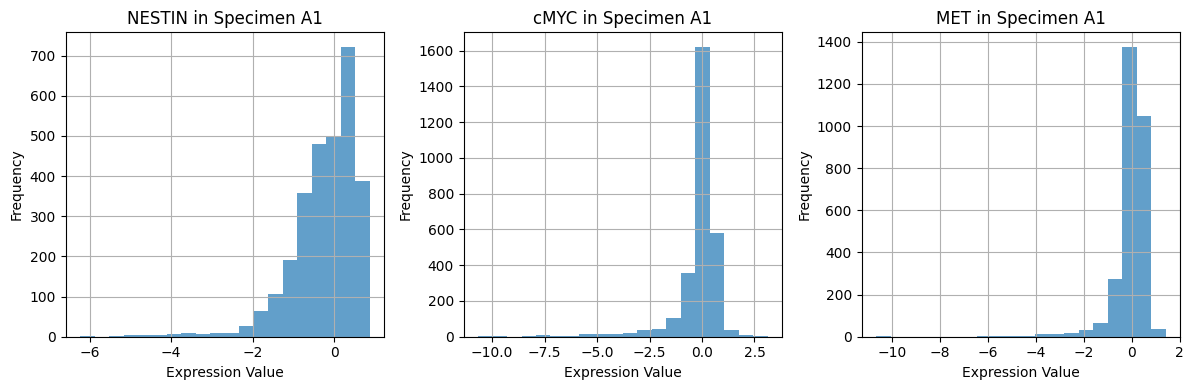

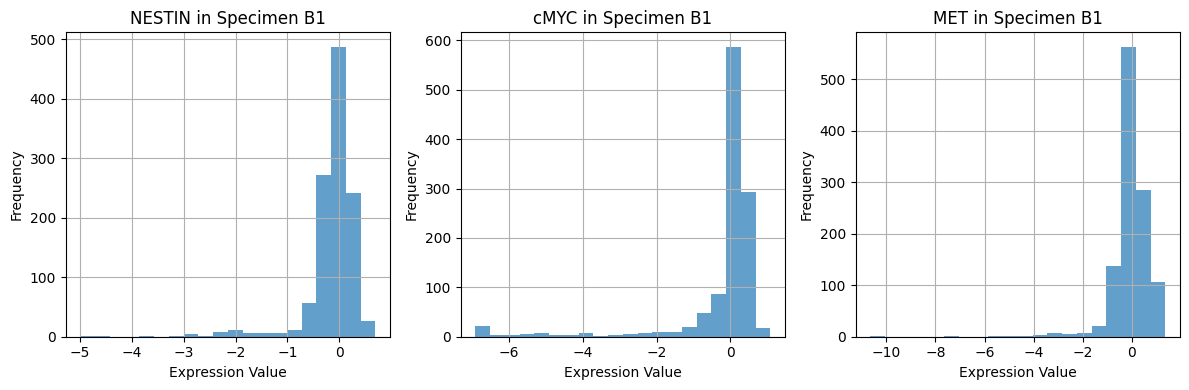

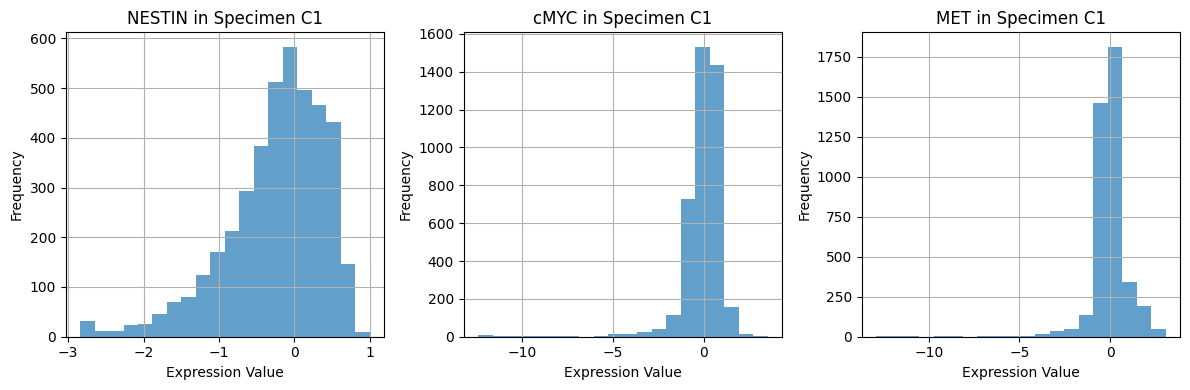

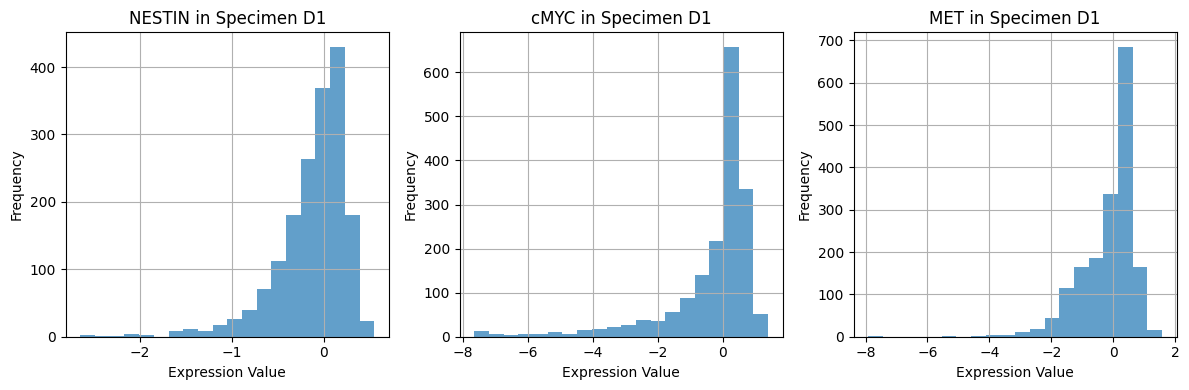

In [3]:
#ii. Protein Expression Histograms: For each specimen,
#generate histograms to visualize the expression values of 'NESTIN', 'cMYC', and 'MET'
#and discuss your observations.
import matplotlib.pyplot as plt

# List of proteins to plot
proteins = ['NESTIN', 'cMYC', 'MET']

# Loop through each unique specimen
for specimen in df['specimen_id'].unique():
    # Filter the DataFrame for the current specimen
    df_specimen = df[df['specimen_id'] == specimen]

    # Create a figure for the histograms
    plt.figure(figsize=(12, 4))

    # Loop through each protein and plot its histogram
    for i, protein in enumerate(proteins, 1):
        plt.subplot(1, 3, i) # 1 row, 3 columns, ith subplot
        df_specimen[protein].hist(bins=20, alpha=0.7)
        plt.title(f'{protein} in Specimen {specimen}')
        plt.xlabel('Expression Value')
        plt.ylabel('Frequency')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


Q.1.ii.
The hisgrams show,

- All specimens show a tendency for left-skewed distributions for all three genes, indicating that there are more low expression values than high values.
- B1 tends to show a narrower range of expression compared to A1.
- C1 consistently shows the most pronounced peaks and the least variability in expression values for all three genes.
- D1 seems to have a balance between the broader range of A1 and the sharp peaks of C1, showing moderate variability and distribution centered slightly closer to zero.

Then
- convert image named start with A1,B1,D1s from RGB to HED color space.
- only show 3 image examples

skimage version: 0.19.3


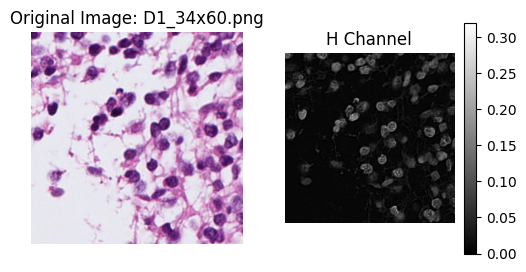

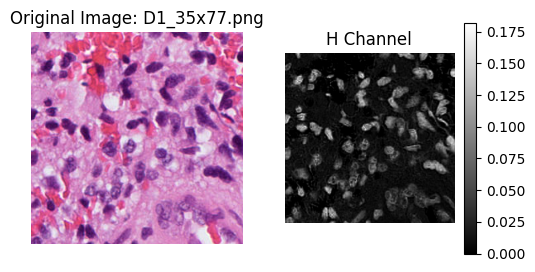

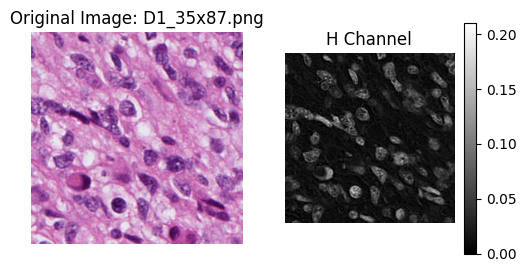

In [5]:
#1.iii
from skimage.color import rgb2hed, rgba2rgb
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import os
import skimage
image_folder = '/content/drive/MyDrive/data mining lab/assignment 2/patches_256'
print('skimage version:', skimage.__version__)

def get_image_paths(directory, image_groups,limit):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            for group in image_groups:
                if file.startswith(group):
                    image_paths.append(os.path.join(root, file))
                    if len(image_paths) == limit:
                        return image_paths
    return image_paths

def convert_and_display(image_paths):
    for example_image_path in image_paths:
        I = imread(example_image_path)
        if I.shape[-1] == 4:
            I = rgba2rgb(I)
        I_hed = rgb2hed(I)
        I_h = I_hed[:, :, 0]  # Extract the H channel

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(I)
        plt.title(f'Original Image: {os.path.basename(example_image_path)}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(I_h, cmap='gray')
        plt.colorbar()
        plt.title('H Channel')
        plt.axis('off')
        plt.show()


directory = image_folder
image_groups = ['A1', 'B1', 'D1']
image_paths = get_image_paths(directory, image_groups,limit=3)
convert_and_display(image_paths)




- I use multiprocessing to parallelize the calculation of average H-channel intensities.
- I also create a file to store the h intensity for each image.

iv. I add a new column to the df to store the H channel average intensity.

In [35]:
def calculate_h_channel_average(row):
    image_file = row.image_id + ".png"
    image_path = os.path.join(image_folder, image_file)
    try:
        I = imread(image_path)
        if I.shape[-1] == 4:
            I = rgba2rgb(I)
        I_hed = rgb2hed(I)
        I_h = I_hed[:, :, 0]
        return np.mean(I_h)
    except Exception as e:
        return None

df['H_channel_average'] = df.apply(calculate_h_channel_average, axis=1)

In [40]:
# Check the first few rows to verify the 'H_channel_average' column
print(df.head())


  image_id  Unnamed: 0                VisSpot  Location_Center_Y  \
0  A1_0x40         412  AAGTAAGCTTCCAAAC-1-A1         764.003658   
1  A1_0x42        7325  GTTTGAGCGGTTATGT-1-A1         799.511111   
2  A1_0x44        8102  TCACTCAGCGCATTAG-1-A1         832.902467   
3  A1_0x46        7085  GTGCGCTTACAAATGA-1-A1         858.343544   
4  A1_0x48        3748  CGAAGACTGCCCGGGA-1-A1         892.179831   

   Location_Center_X      SMAa     CD11b      CD44      CD31      CDK4  ...  \
0         247.700528 -2.895476 -1.445686 -1.875972 -3.456108  0.461409  ...   
1         184.389514 -2.895476 -1.198798 -2.070174 -3.456108 -0.002521  ...   
2         109.598681 -2.895476 -1.631987 -1.920100 -3.456108  0.549366  ...   
3          42.981582 -2.895476 -1.922144 -1.941790 -3.456108  0.639180  ...   
4         958.319117 -2.895476 -0.579756 -2.300428 -3.456108  0.448388  ...   

       DNA3      MHCI      CD68      CD14      KI67      CD16     SOX10    id  \
0  0.924488  0.015759 -0.587511 -1.

H_channel_average has been added sucessfully. then plot.

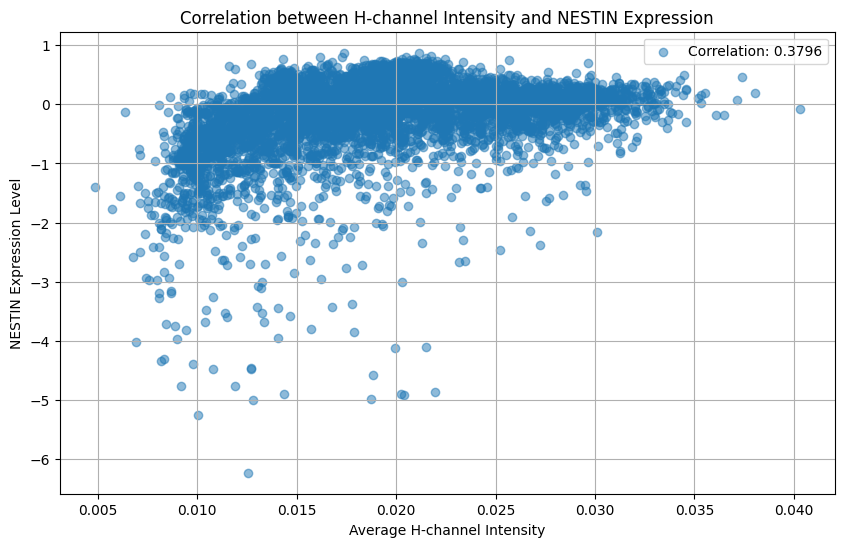

Correlation coefficient: 0.3796


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

filtered_df = df[df['specimen_id'].isin(['A1', 'B1', 'D1'])]
plt.figure(figsize=(10, 6))
correlation_coeff = filtered_df['H_channel_average'].corr(filtered_df['NESTIN'])

plt.scatter(filtered_df['H_channel_average'], filtered_df['NESTIN'], alpha=0.5, label=f'Correlation: {correlation_coeff:.4f}')
plt.xlabel('Average H-channel Intensity')
plt.ylabel('NESTIN Expression Level')
plt.title('Correlation between H-channel Intensity and NESTIN Expression')
plt.grid(True)
plt.legend()
plt.show()
print(f"Correlation coefficient: {correlation_coeff:.4f}")


Q.1.iv Discuss the potential of H-channel average as a predictive feature for NESTIN expression.

- A correlation coefficient of 0.3796 suggests a moderate, positive linear relationship between the average H-channel intensity and NESTIN expression levels .
- The moderate correlation suggests that H-channel average intensity holds some predictive power for NESTIN expression. But as a single predictive feature, it might not be sufficient for precise predictions due to the moderate correlation strength.
- When developing predictive models for NESTIN expression, including H-channel average intensity as one of the features could improve the model's performance.

1.v. Discuss suitable performance metrics for predicting protein expression from images. Identify the most appropriate metric for this specific problem and justify your choice.
- R² and RMSE. Because they provide a clear indication of how well the model can explain the variation in the data and the magnitude of error

# Question 2

---



# i
- Calculate the average and variance for each of the 'H' (from HED), red, green, and blue channels.
- ? extract feature from all the training data and only use one image to example, show the result? or show the result of all the training data?

take A1_0x40.png as an example to calcuate the average and variance for each of the 'H' (from HED), red, green, and blue channels and GLCM.


In [ ]:
import numpy as np
example_image_path = image_folder+'/A1_0x40.png'
I = rgba2rgb(imread(example_image_path)) #read sample RGB image
I_hed =  rgb2hed(I) #convert to HED

I_h = I_hed[:,:,0]; I_e = I_hed[:,:,1]; I_d = I_hed[:,:,2];

# Calculate average and variance for HED channels
avg_h = np.mean(I_h); var_h = np.var(I_h)
avg_e = np.mean(I_e); var_e = np.var(I_e)
avg_d = np.mean(I_d); var_d = np.var(I_d)

# Calculate average and variance for RGB channels
avg_r = np.mean(I[:, :, 0]); var_r = np.var(I[:, :, 0])
avg_g = np.mean(I[:, :, 1]); var_g = np.var(I[:, :, 1])
avg_b = np.mean(I[:, :, 2]); var_b = np.var(I[:, :, 2])

print(f"H channel - Avg: {avg_h:.4f}, Var: {var_h:.4f}");print(f"E channel - Avg: {avg_e:.4f}, Var: {var_e:.4f}")
print(f"D channel - Avg: {avg_d:.4f}, Var: {var_d:.4f}");print(f"R channel - Avg: {avg_r:.4f}, Var: {var_r:.4f}")
print(f"G channel - Avg: {avg_g:.4f}, Var: {var_g:.4f}");print(f"B channel - Avg: {avg_b:.4f}, Var: {var_b:.4f}")

H channel - Avg: 0.0135, Var: 0.0004
E channel - Avg: 0.0147, Var: 0.0004
D channel - Avg: 0.0131, Var: 0.0002
R channel - Avg: 0.8489, Var: 0.0159
G channel - Avg: 0.7113, Var: 0.0474
B channel - Avg: 0.8237, Var: 0.0208


In [ ]:
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import numpy as np

I_gray = rgb2gray(I)  # Convert to grayscale
I_gray = (I_gray * 255).astype(np.uint8)  # Convert to uint8

# Compute GLCM
distances = [1]  # Distance between pixel pairs
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0, 45, 90, 135 degrees
glcm = graycomatrix(I_gray, distances, angles, 256, symmetric=True, normed=True)

# Compute texture features from GLCM
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')
ASM = graycoprops(glcm, 'ASM')  # Angular Second Moment

# Example of how to print the contrast for all directions
print(f"Contrast: {contrast}")


Contrast: [[182.3600337  316.73101115 212.12630208 401.78028451]]


In [48]:
from skimage.color import rgb2hed, rgba2rgb
from skimage.io import imread
import numpy as np
import pandas as pd

# Generating the list of image paths for the filtered DataFrame
image_paths = [image_folder + '/' + row['image_id'] + '.png' for index, row in filtered_df.iterrows()]

def calculate_image_features(image_paths):
    # Initialize a list to store image features
    features_list = []

    for image_path in image_paths:
        try:
            # Read and convert image
            I = imread(image_path)
            if I.shape[-1] == 4:  # Check if image is RGBA, then convert to RGB
                I = rgba2rgb(I)
            I_hed = rgb2hed(I)  # Convert RGB to HED

            # Calculate averages and variances for HED channels
            avg_h, var_h = np.mean(I_hed[:,:,0]), np.var(I_hed[:,:,0])
            avg_e, var_e = np.mean(I_hed[:,:,1]), np.var(I_hed[:,:,1])
            avg_d, var_d = np.mean(I_hed[:,:,2]), np.var(I_hed[:,:,2])

            # Calculate averages and variances for RGB channels
            avg_r, var_r = np.mean(I[:, :, 0]), np.var(I[:, :, 0])
            avg_g, var_g = np.mean(I[:, :, 1]), np.var(I[:, :, 1])
            avg_b, var_b = np.mean(I[:, :, 2]), np.var(I[:, :, 2])

            # Append the features for the current image to the list
            features_list.append([avg_h, var_h, avg_e, var_e, avg_d, var_d, avg_r, var_r, avg_g, var_g, avg_b, var_b])
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    # Convert list of features into a DataFrame
    features_df = pd.DataFrame(features_list, columns=['avg_h', 'var_h', 'avg_e', 'var_e', 'avg_d', 'var_d',
                                                       'avg_r', 'var_r', 'avg_g', 'var_g', 'avg_b', 'var_b'],
                               index=[path.split('/')[-1].split('.')[0] for path in image_paths])
    return features_df
print(features_df)

            avg_h     var_h     avg_e     var_e     avg_d     var_d  \
A1_0x40  0.013534  0.000378  0.014727  0.000447  0.013064  0.000194   
A1_0x42  0.015797  0.000390  0.030326  0.000445  0.022745  0.000192   
A1_0x44  0.015550  0.000353  0.035165  0.000353  0.024612  0.000126   
A1_0x46  0.017684  0.000379  0.041112  0.000352  0.027499  0.000118   
A1_0x48  0.017878  0.000430  0.043775  0.000351  0.029226  0.000126   
...           ...       ...       ...       ...       ...       ...   
D1_9x63  0.022720  0.000841  0.014816  0.000442  0.011984  0.000171   
D1_9x65  0.029724  0.001032  0.025697  0.000494  0.016945  0.000146   
D1_9x67  0.031511  0.001079  0.027033  0.000467  0.017110  0.000134   
D1_9x69  0.029586  0.001038  0.026072  0.000509  0.016507  0.000134   
D1_9x71  0.028061  0.000861  0.024956  0.000437  0.015892  0.000124   

              avg_r        var_r       avg_g        var_g       avg_b  \
A1_0x40    0.848883     0.015943    0.711311     0.047447    0.823697   
A

Q.2.I.2

GLCM (Gray Level Co-occurrence Matrix): GLCM features can provide insights into the texture of the image, capturing aspects like contrast, correlation, and homogeneity, which might be relevant for distinguishing between different image types. See scikit-image GLCM features for more information.

# ii

create scatter plots to compare the true and predicted values on the test data, and use RMSE, Pearson Correlation Coefficient and R2 score to evaluate and report  models' performance.

In [49]:
# feature extration
import pandas as pd
import numpy as np
from skimage import io, color
from skimage.feature import graycomatrix, graycoprops
import statsmodels.api as sm
from skimage.io import imread
import os
from skimage.color import rgb2gray, rgba2rgb
import glob

df['image_id'] = df.VisSpot.apply(lambda x: x.split('-')[2]) + '_' + df.id
image_folder = '/content/drive/MyDrive/data mining lab/assignment 2/patches_256'
filtered_df = df[df['specimen_id'].isin(['A1', 'B1', 'D1'])]

# Extract protein names by excluding non_protein_columns
filtered_df_columns = filtered_df.columns
non_protein_columns = ['Unnamed: 0', 'VisSpot', 'Location_Center_Y', 'Location_Center_X', 'id', 'specimen_id']
target_proteins = [col for col in filtered_df_columns if col not in non_protein_columns]
features_df = calculate_image_features(image_paths)


def extract_features(image):
    # Convert to grayscale for GLCM on RGB channels
    gray_image = rgb2gray(image)
    # GLCM calculation (distance=1, angle=0 for demonstration; adjust as needed)
    glcm = graycomatrix((gray_image * 255).astype('uint8'), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)

    # Extracting GLCM features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': dissimilarity,
        'homogeneity': homogeneity,'energy': energy,
        'correlation': correlation,'ASM': ASM,
    }
def process_batch(images, batch_size=100):
    features_list = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        for image_path in batch:
            image = imread(image_path)
            if image.shape[-1] == 4:
                image = rgba2rgb(image)
            features = extract_features(image)
            features_list.append(features)
    return features_list

image_paths = [os.path.join(image_folder, f"{img_id}.png") for img_id in filtered_df['image_id']]
batch_size = 100
all_features = process_batch(image_paths, batch_size=batch_size)

for _, row in filtered_df.iterrows():
    # Constructing the image path
    image_file = row.image_id + ".png"
    image_path = os.path.join(image_folder, image_file)
    # Reading the image
    image = imread(image_path)
    if image.shape[-1] == 4:
       image = rgba2rgb(image)
    extracted_features = extract_features(image)
    target_value = row['target_column']

# Convert the collected features and targets into a DataFrame
features_df = pd.DataFrame(all_features)


KeyError: 'target_column'

In [ ]:
#Ordinary Least Squares (OLS) Regression
for protein in target_proteins:
    # Preparing the data
    y = filtered_df[protein]
    X = features_df.loc[filtered_df.index]

    # Adding a constant for OLS
    X = sm.add_constant(X)

    # Splitting the dataset into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fitting the OLS model
    model = sm.OLS(y_train, X_train).fit()

    # Predictions
    y_pred = model.predict(X_test)

    # Evaluating the model
    print(f"Model for {protein}:")
    print("R-squared:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("---------\n")



In [ ]:
# Support Vector Regression (SVR)


# Question 3